# Time Series Forecasting: Household Electric Power Consumption




## Author: Arash Sadeghzadeh



The data for this norebook can be retrieved from the following URL: \
https://www.kaggle.com/datasets/uciml/electric-power-consumption-data-set


In this notebook, we consider the problem of time series forecasting using DNN, LSTM, and LSTM with CONV1D.

The developed methods are evaluated using Household Electric Power Consumption dataset from Kaggle. 
The dataset comprises the measurements of electric power consumption in one household with a one-minute sampling rate over a period of almost 4 years


## Table of Contents
* [Data Exploration](#first-bullet)
* [Helper Functions](#second-bullet)
* [Prepare Train and Validation Dataset](#third-bullet)
* [DNN Time Series Forecasting Model](#fourth-bullet)
    - [Choose Learning Rate](#41)
    - [Train NN](#42)
* [LSTM Time Series Forecasting Model](#fifth-bullet)
* [LSTM-Conv1D Time Series Forecasting Model](#sixth-bullet) 
    

## Data Exploration  <a class="anchor" id="first-bullet"></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import MaxAbsScaler


print(tf.__version__)

2.8.0


In [2]:
path = './household_power_consumption.txt'
data = pd.read_csv(path, delimiter=';', parse_dates={'date_time':['Date','Time']},
                   infer_datetime_format=True, na_values=['nan','?'], 
                   index_col='date_time')

Let's have a look at the dataset:

In [3]:
data.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
date_time,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


To get more familiar with data, let's have a look at the data type of the columns and the number of samples in the dataset:

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


For example

We also need to check whether there exist missing values in the dataset:

In [5]:
data.isna().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

There exist some missing values, we take care of those values as follows:

In [6]:
data.fillna(method="bfill", inplace=True)

In [7]:
data.isna().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

We have considered the problem of forecasting 'Global_active_power'. To proceeed further, let's first have a look at that time series data:

In [8]:
# Energy in every minute (watt-hour)
series = data['Global_active_power'] * 1000 / 60

In [9]:
series.describe().round(2)

count    2075259.00
mean          18.24
std           17.58
min            1.27
25%            5.17
50%           10.33
75%           25.60
max          185.37
Name: Global_active_power, dtype: float64

In [10]:
# Energy in every hour
data = series.resample('h').sum()
data.head()

date_time
2006-12-16 17:00:00    2533.733333
2006-12-16 18:00:00    3632.200000
2006-12-16 19:00:00    3400.233333
2006-12-16 20:00:00    3268.566667
2006-12-16 21:00:00    3056.466667
Freq: H, Name: Global_active_power, dtype: float64

In [11]:
data = data.to_numpy()

Before starting to develope the models, we scale the data using MaxAbsScaler: 

In [12]:
scaler = MaxAbsScaler()
data = scaler.fit_transform(X=data[:, np.newaxis])
data = data.squeeze()

## Helper Functions <a class="anchor" id="second-bullet"></a>

In the following, we defined two helper functions to prepare the training and validation data as datasets and to plot the predicted values by the models:

In [13]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer=None):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size +1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    if shuffle_buffer:
        dataset = dataset.shuffle(shuffle_buffer)
        
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [14]:
def plot_series(x, y, ax, format="-", start=0, end=None,  
                title=None, xlabel=None, ylabel=None, label=None):
    '''This function plot a given series'''
    ax.plot(x[start:end], y[start:end], format, label=label)
    ax.set(xlabel=xlabel, ylabel=ylabel, title=title)
    ax.legend()
    ax.grid(True)

## Prepare Train and Validation Dataset <a class="anchor" id="third-bullet"></a>

In this section, using the previously developed helper functions, we prepare the required datasets for training and validation procedures:

In [15]:
window_size = 36
batch_size = 64
shuffle_buffer = 10000

In [16]:
split_time = 30000

tra_data = windowed_dataset(data[:split_time], window_size, batch_size, shuffle_buffer)

val_data = windowed_dataset(data[split_time:], window_size, batch_size, shuffle_buffer) 

2022-09-23 11:38:02.170043: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## DNN Time Series Forecasting Model  <a class="anchor" id="fourth-bullet"></a>

The first method we develope for the time series forecasting is a model based on Deep Neural Network (DNN).

### Choose Learning Rate <a class="anchor" id="41"></a>

Choosing the learning rate is an important issue. To take care of that, in this section, we use LearningRate Scheduler to train the NN in 150 epochs, then, based on the obtained loss values for each value of the considered learning rate, we will be able to choose an appropriate learning rate.

In [17]:
tf.keras.backend.clear_session()
model = tf.keras.models.Sequential([
                    tf.keras.layers.Dense(units=64, input_shape=[window_size], activation='relu'),
                    tf.keras.layers.Dropout(0.4),
                    tf.keras.layers.Dense(units=32, activation='relu'),
                    tf.keras.layers.Dropout(0.2),
                    tf.keras.layers.Dense(units=1)
    ])

In [18]:
optimizer = tf.keras.optimizers.SGD()
loss = tf.keras.losses.Huber()

In [19]:
learn_sch = tf.keras.callbacks.LearningRateScheduler(
                    lambda epoch: 1e-6 * 10**(epoch / 20))

In [20]:
model.compile(optimizer=optimizer, loss=loss, metrics=['mae'])

In [21]:
history = model.fit(tra_data, epochs=150, validation_data=val_data,
                   callbacks=[learn_sch])

Epoch 1/150
469/469 [==============================] - 5s 7ms/step - loss: 0.0572 - mae: 0.2744 - val_loss: 0.0264 - val_mae: 0.1909 - lr: 1.0000e-06
Epoch 2/150
469/469 [==============================] - 3s 5ms/step - loss: 0.0570 - mae: 0.2740 - val_loss: 0.0263 - val_mae: 0.1906 - lr: 1.1220e-06
Epoch 3/150
469/469 [==============================] - 3s 5ms/step - loss: 0.0571 - mae: 0.2745 - val_loss: 0.0262 - val_mae: 0.1903 - lr: 1.2589e-06
Epoch 4/150
469/469 [==============================] - 3s 5ms/step - loss: 0.0569 - mae: 0.2745 - val_loss: 0.0262 - val_mae: 0.1899 - lr: 1.4125e-06
Epoch 5/150
469/469 [==============================] - 3s 6ms/step - loss: 0.0567 - mae: 0.2728 - val_loss: 0.0261 - val_mae: 0.1895 - lr: 1.5849e-06
Epoch 6/150
469/469 [==============================] - 3s 6ms/step - loss: 0.0563 - mae: 0.2721 - val_loss: 0.0260 - val_mae: 0.1890 - lr: 1.7783e-06
Epoch 7/150
469/469 [==============================] - 3s 5ms/step - loss: 0.0564 - mae: 0.2721 - va

469/469 [==============================] - 4s 6ms/step - loss: 0.0053 - mae: 0.0758 - val_loss: 0.0032 - val_mae: 0.0549 - lr: 0.2818
Epoch 111/150
469/469 [==============================] - 4s 6ms/step - loss: 0.0052 - mae: 0.0749 - val_loss: 0.0029 - val_mae: 0.0562 - lr: 0.3162
Epoch 112/150
469/469 [==============================] - 4s 6ms/step - loss: 0.0052 - mae: 0.0743 - val_loss: 0.0029 - val_mae: 0.0575 - lr: 0.3548
Epoch 113/150
469/469 [==============================] - 4s 6ms/step - loss: 0.0051 - mae: 0.0736 - val_loss: 0.0030 - val_mae: 0.0533 - lr: 0.3981
Epoch 114/150
469/469 [==============================] - 4s 6ms/step - loss: 0.0051 - mae: 0.0735 - val_loss: 0.0029 - val_mae: 0.0541 - lr: 0.4467
Epoch 115/150
469/469 [==============================] - 4s 6ms/step - loss: 0.0050 - mae: 0.0727 - val_loss: 0.0030 - val_mae: 0.0620 - lr: 0.5012
Epoch 116/150
469/469 [==============================] - 4s 6ms/step - loss: 0.0050 - mae: 0.0725 - val_loss: 0.0030 - val_mae

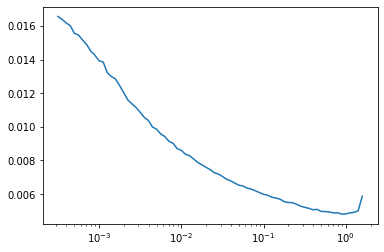

In [22]:
learn_value = 1e-6 * (10 ** (np.arange(150) / 20))
plt.semilogx(learn_value[50:125], history.history['loss'][50:125])
plt.tick_params(axis='both', which='both')
plt.show()

As one can see in the above figure, a learning rate around 0.1 may lead to an stable and reasonable learning procedure.

### Train NN  <a class="anchor" id="42"></a>

Now we choose the learning rate as 0.1 and once again train the NN to obtain the model:

In [23]:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
                    tf.keras.layers.Dense(units=64, input_shape=[window_size],  activation='relu'),
                    tf.keras.layers.Dropout(0.4),
                    tf.keras.layers.Dense(units=32, activation='relu'),
                    tf.keras.layers.Dropout(0.2),
                    tf.keras.layers.Dense(units=1)
    ])

learning_rate = 1e-1

best_model_callback = tf.keras.callbacks.ModelCheckpoint('best_DNN.h5', monitor='val_mae', save_best_only=True, 
                                                         verbose=1)

optimizer = tf.keras.optimizers.SGD(lr=learning_rate)
loss = tf.keras.losses.Huber()

model.compile(optimizer=optimizer, loss=loss, metrics=['mae'])

history = model.fit(tra_data, epochs=60, validation_data=val_data, 
                    callbacks=[best_model_callback])

Epoch 1/60


/Users/arash/mlp/lib/python3.9/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


    456/Unknown - 4s 5ms/step - loss: 0.0107 - mae: 0.1113
Epoch 1: val_mae improved from inf to 0.07796, saving model to best_DNN.h5
469/469 [==============================] - 5s 7ms/step - loss: 0.0106 - mae: 0.1109 - val_loss: 0.0044 - val_mae: 0.0780
Epoch 2/60
458/469 [============================>.] - ETA: 0s - loss: 0.0079 - mae: 0.0967
Epoch 2: val_mae improved from 0.07796 to 0.06976, saving model to best_DNN.h5
469/469 [==============================] - 4s 7ms/step - loss: 0.0079 - mae: 0.0967 - val_loss: 0.0039 - val_mae: 0.0698
Epoch 3/60
466/469 [============================>.] - ETA: 0s - loss: 0.0073 - mae: 0.0923
Epoch 3: val_mae improved from 0.06976 to 0.06703, saving model to best_DNN.h5
469/469 [==============================] - 4s 7ms/step - loss: 0.0073 - mae: 0.0923 - val_loss: 0.0038 - val_mae: 0.0670
Epoch 4/60
441/469 [===========================>..] - ETA: 0s - loss: 0.0069 - mae: 0.0889
Epoch 4: val_mae improved from 0.06703 to 0.06546, saving model to best_

469/469 [==============================] - 4s 6ms/step - loss: 0.0052 - mae: 0.0744 - val_loss: 0.0029 - val_mae: 0.0567
Epoch 31/60
457/469 [============================>.] - ETA: 0s - loss: 0.0051 - mae: 0.0738
Epoch 31: val_mae did not improve from 0.05530
469/469 [==============================] - 4s 6ms/step - loss: 0.0051 - mae: 0.0738 - val_loss: 0.0029 - val_mae: 0.0562
Epoch 32/60
445/469 [===========================>..] - ETA: 0s - loss: 0.0051 - mae: 0.0737
Epoch 32: val_mae improved from 0.05530 to 0.05524, saving model to best_DNN.h5
469/469 [==============================] - 4s 6ms/step - loss: 0.0051 - mae: 0.0737 - val_loss: 0.0030 - val_mae: 0.0552
Epoch 33/60
459/469 [============================>.] - ETA: 0s - loss: 0.0051 - mae: 0.0733
Epoch 33: val_mae did not improve from 0.05524
469/469 [==============================] - 4s 6ms/step - loss: 0.0051 - mae: 0.0733 - val_loss: 0.0029 - val_mae: 0.0559
Epoch 34/60
466/469 [============================>.] - ETA: 0s - l

Now, to evaluate the obtained model, let's have a look at true values and predicted values by our model:

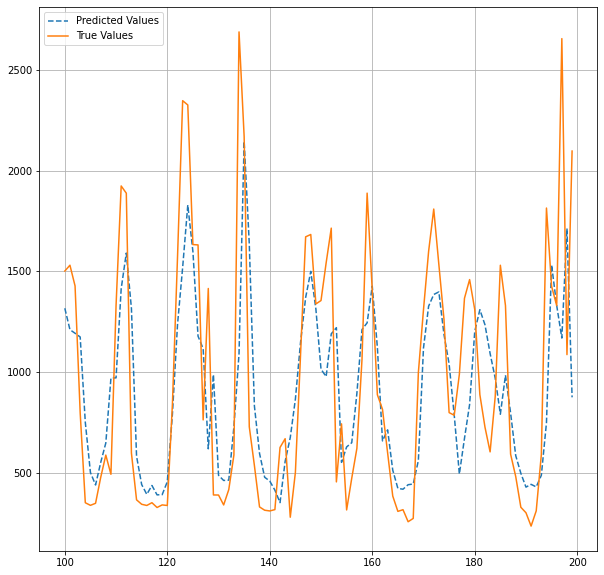

In [24]:
DNN_best = tf.keras.models.load_model('best_DNN.h5')

# set shuffle_buffer=None to avoid shuffeling the data
tes_data = windowed_dataset(data[split_time:], window_size, batch_size, 
                            shuffle_buffer=None)

y_pred = DNN_best.predict(tes_data)

y_pred_rescaled = scaler.max_abs_ * y_pred
data_rescaled =  scaler.max_abs_ * data

x = range(len(y_pred_rescaled))

fig, ax = plt.subplots(figsize=(10,10))
plot_series(x, y_pred_rescaled, ax=ax, format="--", start=100, end=200,  
                title='Predicted and True values of Energy Consumption: Using DNN Model', 
                xlabel='time', ylabel='Value', label='Predicted Values')

plot_series(x, data_rescaled[split_time+window_size:], ax=ax, format="-", start=100,
            end=200, title=None, xlabel=None, ylabel=None, label='True Values')

Furthermore, lets plot both loss and validation mean absolute error (MAE):

In [25]:
def loss_val_accuracy_plot(history, begin=None, end=None):
        fig,ax = plt.subplots(figsize=(7,7))

        ln1 = ax.plot(range(len(history.history['loss']))[begin:end], 
                 history.history['loss'][begin:end], 'b', label='Loss')
        ax.set(ylabel='Loss', xlabel='epoch')
        
        ax2 = ax.twinx()
        ln2 = ax2.plot(range(len(history.history['val_mae']))[begin:end],
                 history.history['val_mae'][begin:end], 'r--',
                 label='Validation MAE')
        
        ax2.set(xlabel='Epoch', ylabel='MAE', 
                title='Loss and validation mean absolute error')
        plt.grid()
        
        ln1, lab1 = ax.get_legend_handles_labels()
        ln2, lab2 = ax2.get_legend_handles_labels()
        ax2.legend(ln1 + ln2, lab1 + lab2, loc=0)
        
        plt.show()

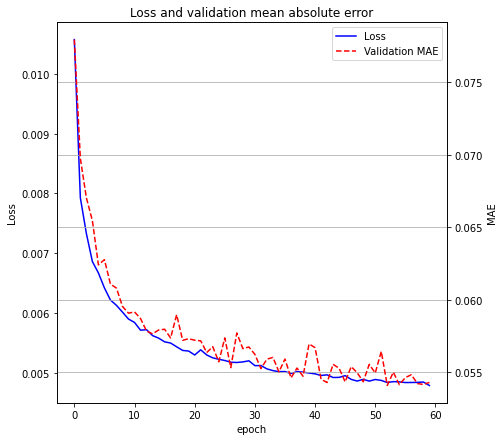

In [26]:
loss_val_accuracy_plot(history, 0,200)

## LSTM Time Series Forecasting Model <a class="anchor" id="fifth-bullet"></a> 

In this section, we consider developing an LSTM time series forecasting model. 

In [27]:
window_size = 36
batch_size = 64
shuffle_buffer = 10000

In [28]:
split_time = 30000

tra_data = windowed_dataset(data[:split_time], window_size, batch_size, shuffle_buffer)

val_data = windowed_dataset(data[split_time:], window_size, batch_size, shuffle_buffer) 

In [29]:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
                    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)),
                    tf.keras.layers.LSTM(units=64, return_sequences=True),
                    tf.keras.layers.LSTM(units=64, return_sequences=True),
                    tf.keras.layers.LSTM(units=32, return_sequences=False),
                    tf.keras.layers.Dense(units=1)
    ])

In [30]:
best_model_callback = tf.keras.callbacks.ModelCheckpoint('best_LSTM.h5', monitor='val_mae', save_best_only=True, 
                                                         verbose=1)

loss = tf.keras.losses.Huber()

model.compile(optimizer='adam', loss=loss, metrics=['mae'])

history = model.fit(tra_data, epochs=15, validation_data=val_data, 
                    callbacks=[best_model_callback])  

Epoch 1/15
    468/Unknown - 36s 64ms/step - loss: 0.0071 - mae: 0.0896
Epoch 1: val_mae improved from inf to 0.05916, saving model to best_LSTM.h5
469/469 [==============================] - 39s 71ms/step - loss: 0.0071 - mae: 0.0895 - val_loss: 0.0031 - val_mae: 0.0592
Epoch 2/15
468/469 [============================>.] - ETA: 0s - loss: 0.0046 - mae: 0.0678
Epoch 2: val_mae improved from 0.05916 to 0.05486, saving model to best_LSTM.h5
469/469 [==============================] - 32s 66ms/step - loss: 0.0046 - mae: 0.0678 - val_loss: 0.0029 - val_mae: 0.0549
Epoch 3/15
468/469 [============================>.] - ETA: 0s - loss: 0.0043 - mae: 0.0650
Epoch 3: val_mae did not improve from 0.05486
469/469 [==============================] - 36s 74ms/step - loss: 0.0043 - mae: 0.0650 - val_loss: 0.0029 - val_mae: 0.0559
Epoch 4/15
468/469 [============================>.] - ETA: 0s - loss: 0.0042 - mae: 0.0637
Epoch 4: val_mae improved from 0.05486 to 0.05312, saving model to best_LSTM.h5
469/

Now, let's compare the true values and the predicted values by the developed model.

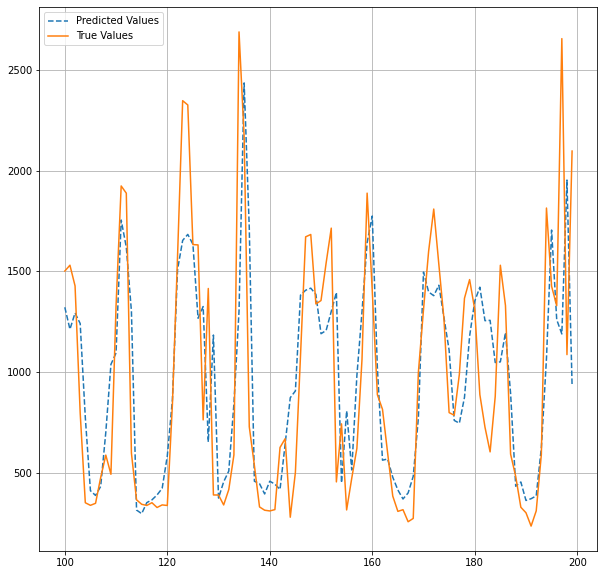

In [31]:
LSTM_model = tf.keras.models.load_model('best_LSTM.h5')

# set shuffle_buffer=None to avoid shuffeling the data
tes_data = windowed_dataset(data[split_time:], window_size, batch_size, 
                            shuffle_buffer=None)

y_pred = LSTM_model.predict(tes_data)
y_pred_rescaled = scaler.max_abs_ * y_pred
data_rescaled =  scaler.max_abs_ * data
a
x = range(len(y_pred_rescaled))

fig, ax = plt.subplots(figsize=(10,10))
plot_series(x, y_pred_rescaled, ax=ax, format="--", start=100, end=200,  
                title='Predicted and True values of Energy Consumption: Using LSTM model', 
                xlabel='time', ylabel='Value', label='Predicted Values')

plot_series(x, data_rescaled[split_time+window_size:], ax=ax, format="-", start=100,
            end=200, title=None, xlabel=None, ylabel=None, label='True Values')

## LSTM-CONV1D Time Series Forecasting Model <a class="anchor" id="sixth-bullet"></a>

Finally, we consider training a model using both LSTM and Conc1D to see whether we are able to obtain a better model in comparison with the previous ones.

In [32]:
window_size = 36
batch_size = 128
shuffle_buffer = 10000

In [33]:
split_time = 30000

tra_data = windowed_dataset(data[:split_time], window_size, batch_size, shuffle_buffer)

val_data = windowed_dataset(data[split_time:], window_size, batch_size, shuffle_buffer) 

In [34]:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
                    tf.keras.layers.Conv1D(filters=32, input_shape=[window_size,1], activation='relu',
                                        kernel_size=5, padding='causal'),
                    tf.keras.layers.LSTM(units=64, return_sequences=True ),
                    tf.keras.layers.LSTM(units=64, return_sequences=True),
                    tf.keras.layers.LSTM(units=32),
                    tf.keras.layers.Dropout(0.2),
                    tf.keras.layers.Dense(units=1)
    ])

In [35]:
model.compile(loss=tf.keras.losses.Huber(), optimizer='adam', metrics=['mae'])

In [36]:
best_model_callback = tf.keras.callbacks.ModelCheckpoint('best_LSTM_CONV.h5', monitor='val_mae', save_best_only=True, 
                                                         verbose=1)

In [37]:
history = model.fit(tra_data, epochs=30, validation_data=val_data, 
                    callbacks=[best_model_callback])

Epoch 1/30
    235/Unknown - 26s 85ms/step - loss: 0.0092 - mae: 0.1059
Epoch 1: val_mae improved from inf to 0.07548, saving model to best_LSTM_CONV.h5
235/235 [==============================] - 29s 98ms/step - loss: 0.0092 - mae: 0.1059 - val_loss: 0.0044 - val_mae: 0.0755
Epoch 2/30
235/235 [==============================] - ETA: 0s - loss: 0.0054 - mae: 0.0757
Epoch 2: val_mae improved from 0.07548 to 0.05395, saving model to best_LSTM_CONV.h5
235/235 [==============================] - 24s 97ms/step - loss: 0.0054 - mae: 0.0757 - val_loss: 0.0030 - val_mae: 0.0540
Epoch 3/30
235/235 [==============================] - ETA: 0s - loss: 0.0047 - mae: 0.0677
Epoch 3: val_mae did not improve from 0.05395
235/235 [==============================] - 24s 95ms/step - loss: 0.0047 - mae: 0.0677 - val_loss: 0.0030 - val_mae: 0.0542
Epoch 4/30
235/235 [==============================] - ETA: 0s - loss: 0.0045 - mae: 0.0659
Epoch 4: val_mae did not improve from 0.05395
235/235 [===================

Now, we can compare the obtained values by the model and the true values:

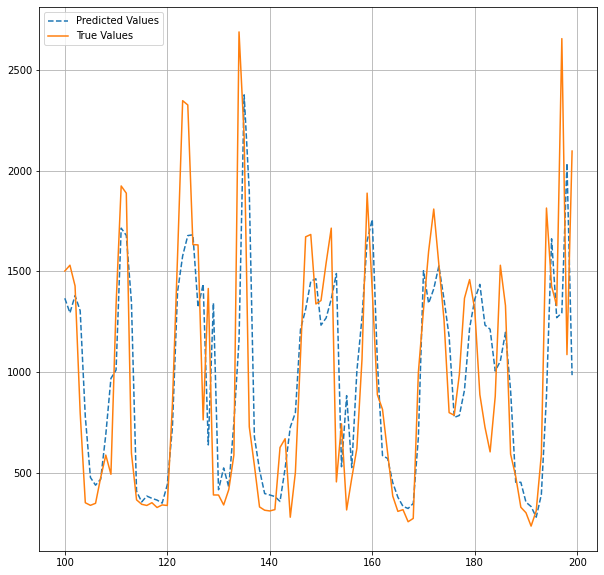

In [38]:
LSTM_CONV = tf.keras.models.load_model('best_LSTM_CONV.h5')

# set shuffle_buffer=None to avoid shuffeling the data
tes_data = windowed_dataset(data[split_time:], window_size, batch_size, 
                            shuffle_buffer=None)

y_pred = LSTM_CONV.predict(tes_data)

y_pred_rescaled = scaler.max_abs_ * y_pred
data_rescaled =  scaler.max_abs_ * data

x = range(len(y_pred_rescaled))

fig, ax = plt.subplots(figsize=(10,10))
plot_series(x, y_pred_rescaled, ax=ax, format="--", start=100, end=200,  
                title='Predicted and True values of Energy Consumption: Using LSTM-CONV Model', 
                xlabel='time', ylabel='Value', label='Predicted Values')

plot_series(x, data_rescaled[split_time+window_size:], ax=ax, format="-", start=100,
            end=200, title=None, xlabel=None, ylabel=None, label='True Values')